# Digits recognition with Neural Networks

In this project I will compare three models that recognizes handwritten digits: 
* Standard Neural Network, 
* Convolutional Neural Network 
* and SGD Classification model.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Flatten
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


Let's check that GPU is working:

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14035070561191575579, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6662668288
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16692162875789640270
 physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"]

## About the data

The MNIST database contains 60,000 training images and 10,000 testing images of digits written by high school students and employees of the United States Census Bureau.

In [3]:
from keras.datasets import mnist

(X, y), (X_test, y_test) = mnist.load_data()

In [4]:
X.shape

(60000, 28, 28)

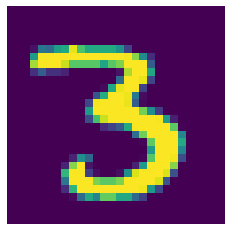

In [5]:
plt.imshow(X[12])
plt.axis("off")
plt.show()

In [6]:
y[12]

3

## Standard Neural Network


#### Preprocessing

In [7]:
# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)

# Vectorizing images
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
X_val = X_val.reshape(X_val.shape[0], num_pixels).astype('float32')

# Normalizing
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
X_val = X_val / X_val.max()

# One hot encoding outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

#### Evaluation metrics

Since Keras have removed f1 score I will create a custom one:

In [8]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Training a model

In [9]:
def create_classification_model():
    model = Sequential()
    model.add(Dense(num_pixels, activation="relu", input_shape=(num_pixels, )))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(y_train.shape[1], activation="softmax"))    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', f1])
    return model

In [10]:
model = create_classification_model()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 6s - loss: 0.2609 - accuracy: 0.9234 - f1: 0.9175 - val_loss: 0.1804 - val_accuracy: 0.9517 - val_f1: 0.9509
Epoch 2/10
 - 5s - loss: 0.0948 - accuracy: 0.9720 - f1: 0.9723 - val_loss: 0.1060 - val_accuracy: 0.9682 - val_f1: 0.9683
Epoch 3/10
 - 5s - loss: 0.0632 - accuracy: 0.9804 - f1: 0.9806 - val_loss: 0.0976 - val_accuracy: 0.9730 - val_f1: 0.9739
Epoch 4/10
 - 5s - loss: 0.0477 - accuracy: 0.9853 - f1: 0.9854 - val_loss: 0.1128 - val_accuracy: 0.9691 - val_f1: 0.9691
Epoch 5/10
 - 5s - loss: 0.0365 - accuracy: 0.9886 - f1: 0.9887 - val_loss: 0.1016 - val_accuracy: 0.9732 - val_f1: 0.9738
Epoch 6/10
 - 5s - loss: 0.0286 - accuracy: 0.9906 - f1: 0.9906 - val_loss: 0.1467 - val_accuracy: 0.9650 - val_f1: 0.9657
Epoch 7/10
 - 5s - loss: 0.0263 - accuracy: 0.9914 - f1: 0.9915 - val_loss: 0.1002 - val_accuracy: 0.9757 - val_f1: 0.9761
Epoch 8/10
 - 5s - loss: 0.0244 - accuracy: 0.9925 - f1: 0.9925 - val_loss: 0.1235 - val_

In [11]:
scores = model.evaluate(X_test, y_test, verbose=0)
accuracy, f1_scores = scores[1], scores[2]
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('F1: {:.2f}%'.format(f1_scores*100))

Accuracy: 97.81%
F1: 97.83%


Very good. Now let's see what Convolutional NN can

# Convolutional Neural Network (CNN)

#### Preprocessing

In [12]:
(X, y), (X_test, y_test) = mnist.load_data()

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)

# 4D reshape
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Normalizing
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
X_val = X_val / X_val.max()

# One hot encoding outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

#### Training a model

In [13]:
num_classes = y_train.shape[1]

def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(5,5), activation="relu", input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(32, kernel_size=(2,2), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', f1])
    return model

In [14]:
cnn_model = create_cnn_model()

In [15]:
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=200, epochs=10, verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 3s - loss: 0.3729 - accuracy: 0.8956 - f1: 0.8494 - val_loss: 0.1282 - val_accuracy: 0.9622 - val_f1: 0.9628
Epoch 2/10
 - 1s - loss: 0.0970 - accuracy: 0.9719 - f1: 0.9721 - val_loss: 0.0894 - val_accuracy: 0.9746 - val_f1: 0.9745
Epoch 3/10
 - 1s - loss: 0.0713 - accuracy: 0.9786 - f1: 0.9789 - val_loss: 0.0789 - val_accuracy: 0.9757 - val_f1: 0.9756
Epoch 4/10
 - 1s - loss: 0.0550 - accuracy: 0.9833 - f1: 0.9837 - val_loss: 0.0671 - val_accuracy: 0.9803 - val_f1: 0.9811
Epoch 5/10
 - 1s - loss: 0.0471 - accuracy: 0.9851 - f1: 0.9855 - val_loss: 0.0544 - val_accuracy: 0.9833 - val_f1: 0.9835
Epoch 6/10
 - 1s - loss: 0.0388 - accuracy: 0.9881 - f1: 0.9883 - val_loss: 0.0524 - val_accuracy: 0.9849 - val_f1: 0.9851
Epoch 7/10
 - 1s - loss: 0.0329 - accuracy: 0.9899 - f1: 0.9900 - val_loss: 0.0502 - val_accuracy: 0.9861 - val_f1: 0.9861
Epoch 8/10
 - 1s - loss: 0.0304 - accuracy: 0.9910 - f1: 0.9910 - val_loss: 0.0540 - val_

In [16]:
scores = cnn_model.evaluate(X_test, y_test, verbose=0)
accuracy, f1_scores = scores[1], scores[2]
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('F1: {:.2f}%'.format(f1_scores*100))

Accuracy: 98.89%
F1: 98.91%


Convolutional neural network shows two times smaller loss. Great!

# SGD Classification model

Just to compare with NN

In [17]:
(X, y), (X_test, y_test) = mnist.load_data()

# Vectorization
X_train = X.reshape(X.shape[0], num_pixels)
X_test = X_train.reshape(X_train.shape[0], num_pixels)

# Normalizing
X_train = X_train / X_train.max()

In [18]:
def print_scores(score):
    print("Accuracy:  {:0.2f}%".format(100*score['test_accuracy'].mean()))
    print("F1 score:  {:0.2f}%".format(100*score['test_f1'].mean()))
    
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average="weighted")
}

In [19]:
clf_model = SGDClassifier(random_state=11)
score = cross_validate(clf_model, X_train, y, cv=3, verbose=3, scoring=scoring, n_jobs=12)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of   3 | elapsed:   12.3s finished


In [20]:
print_scores(score)

Accuracy:  90.65%
F1 score:  90.61%


Good results but not as fantastic as CNN shows

## Save the model

In [21]:
cnn_model.save('mnist_nn.h5')